# Exercise 2

Look at data in the file “secreckeys_exe.csv”, which is placed in the google folder.

1. Assuming that there is an invariance of the results with respect to shift of the digits in a data sample (e.g. 1234567 and 7123456 give the same result y=0 or y=1), try to improve the accuracy of the model over the validation data set by “augmenting” the data. In practice, for every sample there are L-1 equivalent ones.
2. Implement a “grid search” as shown in NB11 to improve one or more of the aspects or parameters of the model. Possible tests include: different activation units (sigmoid, relu, elu, etc.), different minimization algorithms (adam, rmsprop, sgd with momentum, etc.), different dropouts, etc.
3. See if any rescaling of data (x: the sequences of 0 and 1 used to feed the network) may improve the results.

In [1]:
import numpy as np

# importing data
fname = 'secretkeys_exe.csv'
data = np.loadtxt(fname, delimiter=',', dtype=int)

L = len(str(data[0,0])) # number of digits
N = len(data)
D = 9 # number of used digits (not the number of digits in a bit of the dataset)
LD = L*D
print('Dataset len: {}'.format(N))
print('Example: {}'.format(data[0,0]))

Dataset len: 3000
Example: 4573627


### Augmenting

In [2]:
def cal(num): 
    ''' function to return an array (dtype=int64) with left shift numbers '''
    digit = L # number of digits from the dataset
    powTen = pow(10, digit - 1) 
    res = [] 
    
    for i in range(digit - 1): 
          
        firstDigit = num // powTen 
          
        # formula to calculate left shift  
        # from previous number 
        left = (num * 10 + firstDigit - 
               (firstDigit * powTen * 10)) 
        res.append(left)
        
        # Update the original number 
        num = left 
        
    return np.array(res, dtype=int)

cal(data[0,0])

array([5736274, 7362745, 3627457, 6274573, 2745736, 7457362])

In [3]:
# Increasing data_training with Augmenting

data_train_aug = np.copy(data)

for i in range(len(data)):
    lab = data[i,1]
    val = data[i,0]
    shift_val = cal(val).reshape(L-1,1) # array of L-1 shifted numbers, then reshaped
    temp = np.hstack((shift_val,[[lab] for _ in range(L-1)])) # shape -> (L-1,2)
    
    data_train_aug = np.concatenate((data_train_aug,temp)) # attaching new data
    
N_train_aug = data_train_aug.shape
print('New dimention of training data, after augmentation: {}'.format(N_train_aug))


# Divide data in x and labels y
x = np.copy(data_train_aug[:,0]) # copy to avoid views (remember: slices returns views not copies)
y = np.copy(data_train_aug[:,1])

New dimention of training data, after augmentation: (21000, 2)


In [4]:
# Expanding data to give to the DNN 
def expand(S):
    '''
    Returns a data point 'expanded', i.e. for each int in S
    we expand it in a series of 0 and 1. 
    E.g. if S = 6 and D = 9 --> returns 000001000 
    See Baiesi's lesson
    '''
    if (len(str(S))!=L):
        raise('mismatch! len(S) must be = to L')
    
    x = [0] * LD # note: LD is global
    p = 10**(L-1)
    j = 0
    for j in range(L):
        q = int(S/p) # first digit
        # 1...9 -> 0...8 Hence we need to use q-1
        x[j*D + (q-1)] = 1
        S -= q*p
        p = p//10
    return x

# Defining dataset with 'expanded format'
x_all = [None] * N_train_aug[0]
for i in range(N_train_aug[0]):
    x_all[i] = expand(x[i])
print('Comparison: {} ---> {}'.format(x[0],x_all[0]))

# convertion to numpy array for keras
x_all = np.array(x_all)

Comparison: 4573627 ---> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


### Building the DNN
The procedure follows the one from the 11th NB of the review

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras.optimizers


# Initializing the model with the hyperparameters that will be
# optimized using the GridSearchCV method
def create_model(activation='relu', optimizer=keras.optimizers.Adam(), dropout_rate=0.2):
    ''' 
    Returns a Sequential() object already initialized 
    and compiled.
    It accept data with lenght D*L = DL
    '''
    
    # instantiate model
    model = Sequential()
    
    # add a dense all-to-all relu layer
    model.add( Dense(LD, input_shape=(LD,), activation = activation) )
    model.add( Dense(max(10,LD//2), activation = activation) )
    model.add( Dense(max(6,LD//4), activation = activation) )
    model.add( Dropout(dropout_rate) ) 
    
    model.add( Dense(1, activation = 'sigmoid') )
    
    # compile the model
    model.compile( loss='binary_crossentropy', 
                    optimizer = optimizer,
                    metrics = ['accuracy'])
    
    return model

Using TensorFlow backend.


### Training pre-GridSearch
Training before the hyperparameters optimization with `GridSearchCV`

In [6]:
# First, we select the validation fraction of data used by
# the Fit method
validation_frac = 0.15 # validation fraction
N_val = int(len(x_all)*validation_frac)

batch_size = 40

dnn = create_model()
fit = dnn.fit( x_all[N_val:], y[N_val:], 
                epochs = 20, batch_size = batch_size,
                validation_data=( x_all[0:N_val], y[0:N_val] ))

Train on 17850 samples, validate on 3150 samples
Epoch 1/20
17850/17850 [==============================] - 2s 85us/step - loss: 0.4986 - accuracy: 0.7650 - val_loss: 0.4332 - val_accuracy: 0.7937
Epoch 2/20
17850/17850 [==============================] - 1s 46us/step - loss: 0.3457 - accuracy: 0.8402 - val_loss: 0.2801 - val_accuracy: 0.8654
Epoch 3/20
17850/17850 [==============================] - 1s 42us/step - loss: 0.2243 - accuracy: 0.9016 - val_loss: 0.2144 - val_accuracy: 0.9054
Epoch 4/20
17850/17850 [==============================] - 1s 69us/step - loss: 0.1788 - accuracy: 0.9231 - val_loss: 0.2024 - val_accuracy: 0.9076
Epoch 5/20
17850/17850 [==============================] - 1s 57us/step - loss: 0.1622 - accuracy: 0.9319 - val_loss: 0.1988 - val_accuracy: 0.9124
Epoch 6/20
17850/17850 [==============================] - 1s 76us/step - loss: 0.1512 - accuracy: 0.9375 - val_loss: 0.1897 - val_accuracy: 0.9140
Epoch 7/20
17850/17850 [==============================] - 1s 38us/ste

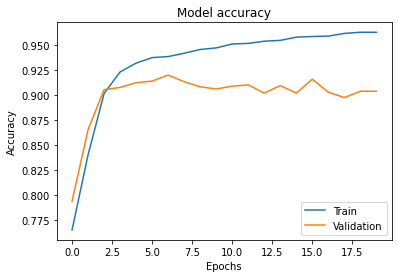

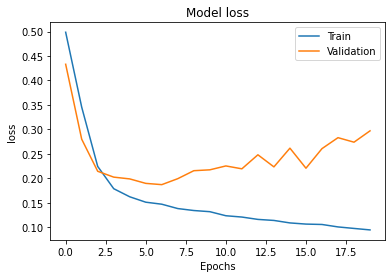

In [7]:
# Visual representation
import matplotlib.pyplot as plt
%matplotlib inline

# Accuracy for train and test (which is the validation)
# Here we use fit.history object
plt.plot(fit.history['accuracy']) # this is on training data
plt.plot(fit.history['val_accuracy']) # this is on validation data
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])

plt.figure()
# Loss (i.e. plotting the cross entropy)
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])

### GridSearch

*Hyper-parameters*: a hyperparameter is a parameter whose value is set before the learning process begins. By contrast, the values of other parameters are derived via training.

Hyperparameters can be classified as *model* hyperparameters, that cannot be inferred while fitting the machine to the training set because they refer to the model selection task, or *algorithm* hyperparameters, that in principle have no influence on the performance of the model but affect the speed and quality of the learning process. An example of the first type is the topology and size of a neural network. An example of the second type is learning rate or mini-batch size.

Based on the following [article](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) 

In [8]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

We're testing the training for the following hyperparameters:
* Optimizer algorithm
* Activation unit (non-linear function for each neuron)
* Dropout fraction

In [9]:
# NOTE: this cell train 375 models, and it takes approx 1 sec for each
# Hence it takes 10 or so minutes to give results

# Call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=create_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=0)

# List of allowed optional arguments for the optimizer, see `create_model()`
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh']
dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8]
# define parameters' dictionary
param_grid = dict(optimizer=optimizer, activation=activation, 
                  dropout_rate=dropout_rate) 

# Call scikit GridSearch module
# n_jobs = number of threads to implement in the computation
# cv = k in the k-fold cross-validation
# the number of model tested is (# of hyperpar to test)*(k for the k-fold cross-val)
grid = GridSearchCV(estimator = model_gridsearch, 
                    param_grid = param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(x_all,y)

# Summarize results
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_) )
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{:.4f} (+- {:.4f}) with: {}".format(mean, stdev, param))


Best: 0.8420476317405701 using {'activation': 'relu', 'dropout_rate': 0.0, 'optimizer': 'Nadam'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.0, 'optimizer': 'SGD'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.0, 'optimizer': 'RMSprop'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.0, 'optimizer': 'Adam'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.0, 'optimizer': 'Adamax'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.0, 'optimizer': 'Nadam'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.2, 'optimizer': 'SGD'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.2, 'optimizer': 'RMSprop'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.2, 'optimizer': 'Adam'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropout_rate': 0.2, 'optimizer': 'Adamax'}
0.7560 (+- 0.0048) with: {'activation': 'softmax', 'dropo

### Trainig post-GridSearch

In [10]:
# Training using the hyperparameters found by GridSearch

dnn_post_grid = create_model(activation = 'relu',
                            optimizer = keras.optimizers.Nadam(),
                            dropout_rate = 0.0)

fit_post_grid = dnn_post_grid.fit( x_all[N_val:], y[N_val:], 
                epochs = 20, batch_size = batch_size,
                validation_data=( x_all[0:N_val], y[0:N_val] ))

Train on 17850 samples, validate on 3150 samples
Epoch 1/20
17850/17850 [==============================] - 1s 48us/step - loss: 0.4136 - accuracy: 0.8053 - val_loss: 0.4221 - val_accuracy: 0.8038
Epoch 2/20
17850/17850 [==============================] - 1s 38us/step - loss: 0.2019 - accuracy: 0.9106 - val_loss: 0.1972 - val_accuracy: 0.9133
Epoch 3/20
17850/17850 [==============================] - 1s 42us/step - loss: 0.1634 - accuracy: 0.9296 - val_loss: 0.1821 - val_accuracy: 0.9257
Epoch 4/20
17850/17850 [==============================] - 1s 34us/step - loss: 0.1518 - accuracy: 0.9347 - val_loss: 0.1830 - val_accuracy: 0.9235
Epoch 5/20
17850/17850 [==============================] - 1s 34us/step - loss: 0.1446 - accuracy: 0.9406 - val_loss: 0.1870 - val_accuracy: 0.9232
Epoch 6/20
17850/17850 [==============================] - 1s 54us/step - loss: 0.1380 - accuracy: 0.9417 - val_loss: 0.1962 - val_accuracy: 0.9133
Epoch 7/20
17850/17850 [==============================] - 1s 66us/ste

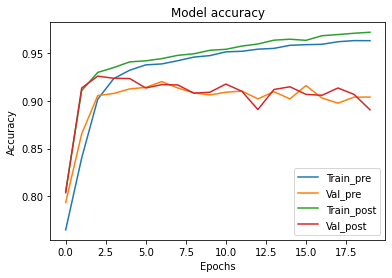

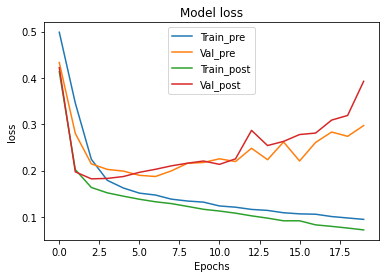

In [11]:
# Here we perform a comparison between before and after the 
# hyperparameters optimization

# Accuracy
plt.plot(fit.history['accuracy']) # this is on training data
plt.plot(fit.history['val_accuracy']) # this is on validation data
plt.plot(fit_post_grid.history['accuracy']) # this is on training data
plt.plot(fit_post_grid.history['val_accuracy']) # this is on validation data
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train_pre','Val_pre','Train_post','Val_post'])

# Loss (i.e. plotting the cross entropy)
plt.figure()
plt.plot(fit.history['loss']) # this is on training data
plt.plot(fit.history['val_loss']) # this is on validation data
plt.plot(fit_post_grid.history['loss'])
plt.plot(fit_post_grid.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Train_pre','Val_pre','Train_post','Val_post'])

Comment: it seems that the optimization of the hyperparameters bring to a similar result or even worst that the original evaluation looking at the loss term.